# Forecasting Electricity Price in the Spain Using Supervised Learning 

### Team: Minho Kang, Lonny Chen, Johannes Müller, 


# 1. Background

# 2. Exploratory Data Analysis

In [18]:
import xgboost as xgb
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from functions import *

In [6]:
df = pd.read_csv('Data/df_clean.csv',index_col="time")

## 2 - 1. Target variable distributions 

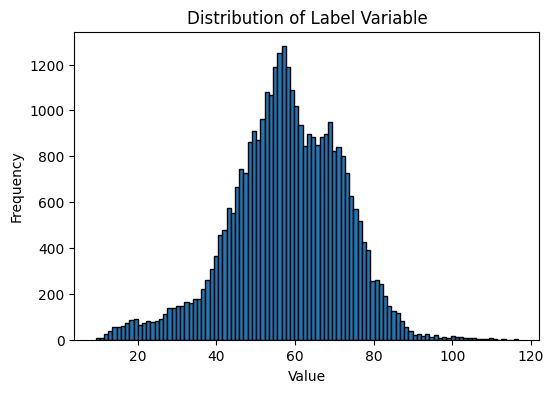

In [13]:
y_price = df['price actual']
plt.figure(figsize=(6, 4))
plt.hist(y_price, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Label Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

**Analysis:** 
- `'price actual'` is the "normal looking" distribution which may help performace of linear regression and "some" machine learning algorithms

## 2 - 2. Feature variables (weather) distributions 

Interesting weather features to take a closer look at:
- temperature, pressure, humidity variations across five cities

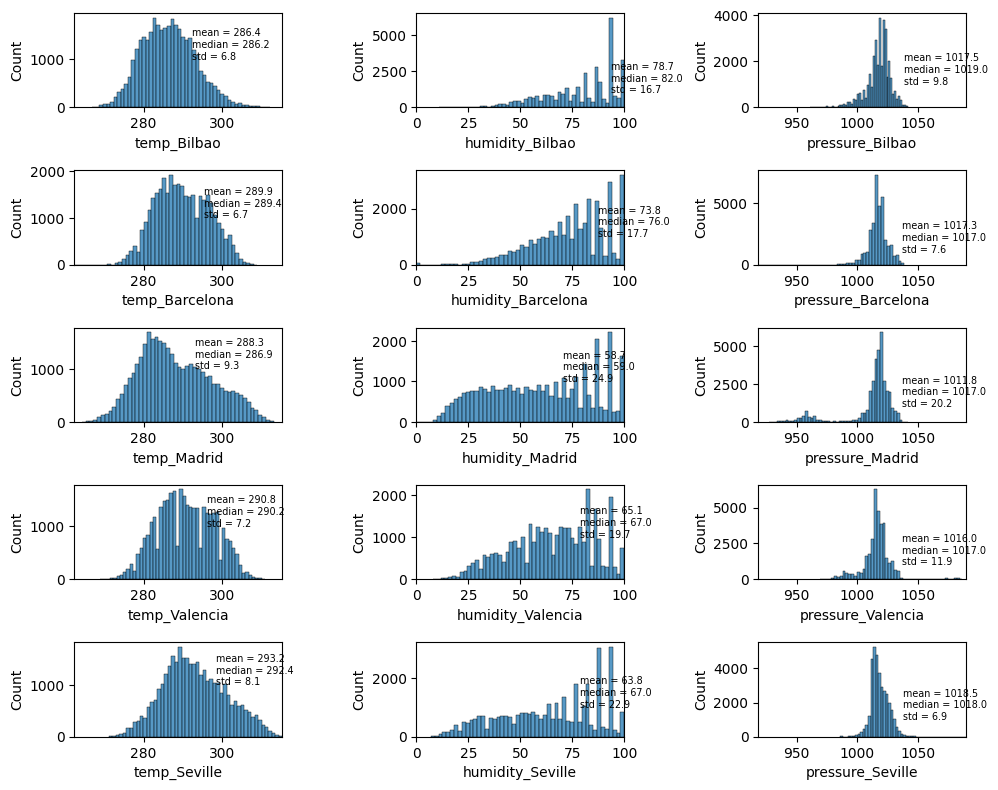

In [19]:
# Setup
weather_cols = [[col for col in df.columns if 'temp' in col],
                [col for col in df.columns if 'humidity' in col],
                [col for col in df.columns if 'pressure' in col]]
# Order by North to South of Spain
for i, _ in enumerate(weather_cols):
    weather_cols[i][0], weather_cols[i][1], weather_cols[i][2], weather_cols[i][3], weather_cols[i][4] = weather_cols[i][1], weather_cols[i][0], weather_cols[i][2], weather_cols[i][4], weather_cols[i][3]

# Get limits for consistent axes
col_mins = [min([min(df[col]) for col in weather_cols[0]]),
            min([min(df[col]) for col in weather_cols[1]]),
            min([min(df[col]) for col in weather_cols[2]])]
col_maxs = [max([max(df[col]) for col in weather_cols[0]]),
            max([max(df[col]) for col in weather_cols[1]]),
            max([max(df[col]) for col in weather_cols[2]])]
fig, axes = plt.subplots(5, 3, figsize=(10, 8))

# Plots and annotate text
for i, x_var in enumerate(weather_cols):
    for j, city in enumerate(x_var):
        sns.histplot(data=df, x=city, bins=50, ax=axes[j][i])
        axes[j][i].set_xlim(left=col_mins[i], right=col_maxs[i])
        hist_text(axes[j][i], np.percentile(df[city], 50), 1000, df[city], 1, 'x-small', False)  
    
plt.tight_layout()
plt.show()

**Observations:** 
- temperature curves do move to the right as we go south, Valencia exhibits some strange dips in the histogram
- humidity curve shapes vary more but it roughly varies inversely to temperature by city (e.g., low temp, high humidity)
- pressure varies little and seems similar in each city

## 2 - 3. Feature variables (generation) correlations

In [20]:
# Calculate correlations
generation_cols = [col for col in df2.columns if 'generation' in col]
df2_generation_corr = df2[generation_cols].corr(method='pearson')

# Plot heatmap
sns.heatmap(df2_generation_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.3)
plt.rcParams['font.size'] = 6

NameError: name 'df2' is not defined

# 3. Feature Engineering using XGboost 

# 4. Model Evaluation

## 4 - 0. Preparation

## 4 - 1. Linear Regression

## 4 - 2. Ridge and Lasso

## 4 - 3. Kernel

## 4 - 4. KNN

## 4 - 5. Tree models (Random Forest and XGboost)

## 4 - 6. RNN

## 4 - 7. Time Series Model

# 5. The final model

# 6. Discussion and Conclusion